Выполнил:
Беляев Степан Константинович

#  Практика 4: Атака DeepFool на модели ИИ

## Шаг 1: Загрузка обученной модели и данных MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9738 - loss: 0.0893
Test accuracy on clean images: 0.9767000079154968


## Шаг 2: Теория атаки DeepFool

 Атака DeepFool — это метод, который был разработан для минимального изменения изображений с
 целью заставить классификационную модель ошибиться. В отличие от других атак, таких как FGSM,
 DeepFool находит минимальные изменения в пространстве признаков, которые достаточны для
 изменения предсказания модели. Это делает DeepFool более эффективной в создании
 противоречивых примеров с минимальным изменением входных данных.

## Шаг 3: Реализация атаки DeepFool с использованием Foolbox

In [3]:
# установка Foolbox
!pip install foolbox

In [5]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения для атаки (например, первое изображение из тестового набора)
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=10)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)  # Оборачиваем метку в тензор с размерностью (1,)

tf.Tensor(7, shape=(), dtype=int64)


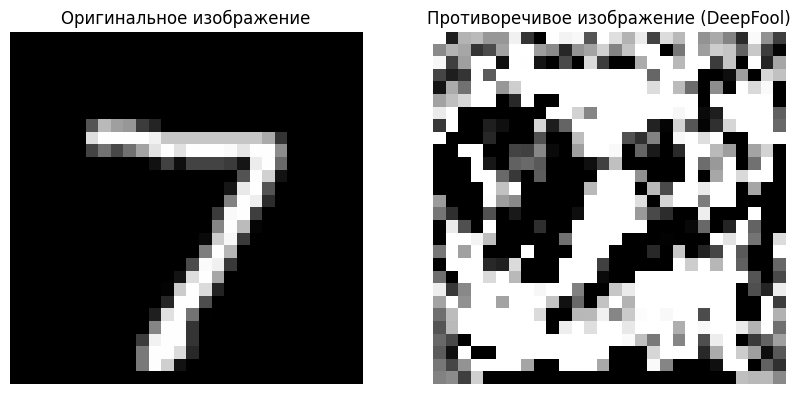

In [18]:
# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")  # Предполагается, что advs имеет правильную форму
plt.axis('off')

plt.show()

# Шаг 4: Оценка модели на противоречивых примерах

In [9]:
adversarial_images = []
# Обработка изображений
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    # Атака на изображение
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)
# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)
# Убедитесь, что test_labels имеют соответствующее количество меток
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 125.4529
Accuracy on adversarial examples (CW attack): 0.0


## Вывод

Как видим, точность модели на атакованных примерах значительно снизилась, и является около 0% (особенно если сравнивать с точностью на исходных данных) в зависимости от силы и шагов атаки. Стоит отметить, что получившееся изображение после атаки визуально сильно отличается от исходного. Более лучшего результата можно добиться при правильном подборе параметров для атаки.
